# CNN Pipeline for Handwritten Digit Classifcation of the MNIST Dataset

**Course:** DVAE26 HT25  
  
**Author** Samuel Lindvall 



## Imports and Environment Setup


In [ ]:
# Core
import numpy as np
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader

# Torchvision 
from torchvision import datasets, transforms

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report


## Constants for training

In [2]:
# Configuration
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10
RANDOM_SEED = 42

## 1. Problem Definition

The goal of this project is to classify grayscale images of handwritten digits (0–9) using a Convolutional Neural Network (CNN).
Each image has a resolution of 28×28 pixels.

**Input:** 28×28 grayscale image  
  
**Output:** Digit label (0–9) 

## 2. Dataset Overview and Data Quality Analysis

The MNIST dataset consists of 70,000 labeled images of handwritten digits:
- 60,000 training samples
- 10,000 test samples



First step is defining the transform for PyTorch and loading the dataset 

In [3]:
# Step one is defining a transformation that converts the data into a PyTorch tensor
# The pixel values are normalized between [0,1]

transform = transforms.Compose([
    transforms.ToTensor()
])

# Using the MNIST class in torchvision we load the training dataset 

train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=False, #Set to true unless kaggle dataset
    transform=transform
)

# Using the MNIST class in torchvision we load the test dataset 
test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=False, #Set to true unless kaggle dataset
    transform=transform
)

Let's start by examining the data and confirming the datasets sizes

In [4]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")


image, label = train_dataset[0]
print("Min pixel value:", image.min().item())
print("Max pixel value:", image.max().item())


print("Shape:", image.shape)

Number of training samples: 60000
Number of test samples: 10000
Min pixel value: 0.0
Max pixel value: 1.0
Shape: torch.Size([1, 28, 28])


These are confirmed to be correct with 60000 training samples
and 10000 test samples. 
The pixel values are normalized as expected.
A single image has the shape of [1, 28, 28] where is the channel dimension (1=grayscale) and it's 28x28.

Now let's visualize the data by looking at the first 5 digits of the training set:

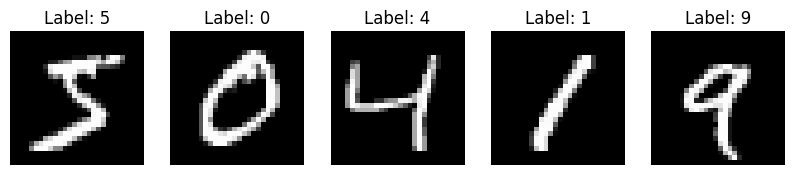

In [5]:

fig, axes = plt.subplots(1,5, figsize=(10,2))
for i, ax in enumerate(axes):
    image, label = train_dataset[i]
    ax.imshow(image.squeeze(), cmap="gray") #Important to remove the channel dimension for imshow
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.show()

A simple check for missing or invalid values:

In [6]:
def check_missing_or_invalid(dataset, name="Dataset"):
    missing_count = 0
    nan_count = 0
    for i in range(len(dataset)):
        image, label = dataset[i]
        if image is None or label is None:
            missing_count += 1
        if torch.isnan(image).any() or torch.isinf(image).any():
            nan_count += 1
    print(f"{name} -> Missing samples: {missing_count}, NaN/Inf values: {nan_count}")

# Run checks
check_missing_or_invalid(train_dataset, "Training Set")
check_missing_or_invalid(test_dataset, "Test Set")


Training Set -> Missing samples: 0, NaN/Inf values: 0
Test Set -> Missing samples: 0, NaN/Inf values: 0


Let's have a look at the distribution of the dataset to make sure we have a somewhat equal representation of digits:

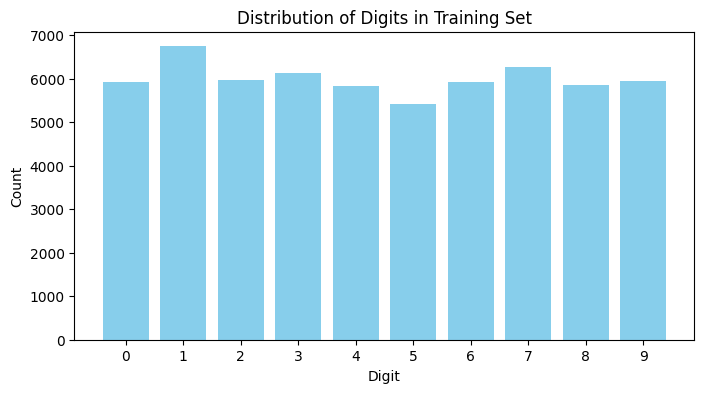

In [7]:
labels = [label for _, label in train_dataset]
plt.figure(figsize=(8,4))
plt.hist(labels, bins=np.arange(11)-0.5, rwidth=0.8, color="skyblue")
plt.xticks(range(10))
plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("Distribution of Digits in Training Set")
plt.show()


Everything looks clear here, labels and numbers looks as expected and the distribution in more or less equal. 

## 3. Data Preprocessing

To make the model generalize better and be more robust to small shifts in handwriting style we can applying small changes to the training data. This also helps prevent overfitting. 

In [15]:
#All of the transforms are applied each time the image is accesed
train_dataset_transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=10, #We allow the image to be rotated +-10 degrees
        translate=(0.1, 0.1),#Shift up to 10% horizontal/vertical
        scale=(0.9, 1.1) #Scaling the image up and down (90%-110%)
    ),
    transforms.ToTensor(),
])

#Test data is not augmented since we want to evaluate on clean data
test_dataset_transform = transforms.Compose([
    transforms.ToTensor(),
])

#Reloading train and test dataset with the new transforms
train_dataset_augmented = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    transform=train_dataset_transform
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=False,
    transform=test_dataset_transform
)

And here is a visualization of what each of the transformations does when applied to the data:

In [ ]:
def show_augmentation_effect():
    """Shows the first image in the dataset alongside 5 augmented versions."""
    fig, axes = plt.subplots(1, 6, figsize=(12, 2))
    
    # Showing original image
    original_image, label = train_dataset[0]
    axes[0].imshow(original_image.squeeze(), cmap="gray")
    axes[0].set_title(f"Original\nLabel: {label}")
    axes[0].axis("off")
    
    # Showing 5 augmented versions
    for i in range(5):
        aug_image, _ = train_dataset_augmented[0]
        axes[i + 1].imshow(aug_image.squeeze(), cmap="gray")
        axes[i + 1].set_title(f"Augmented {i + 1}")
        axes[i + 1].axis("off")
    
    plt.suptitle("Effect of Data Augmentation", fontsize=12)
    plt.tight_layout()
    plt.show()



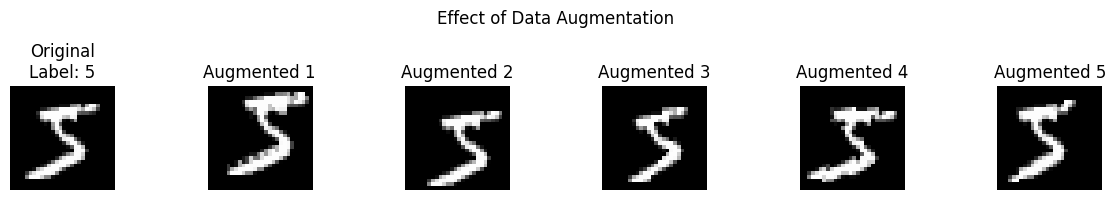

In [29]:
show_augmentation_effect()

Since the effects are randomized, running this several times will yield different results. 

## 4. CNN Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        #First convolution, in channel = 1 because it's a grayscale image. 
        #Using a standard 32 kernels which are 3x3 pixels 
        #And a padding border of 1 to keep output the same size:
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        #Maxpooling to shrink the image, this shrinks it by half the pixel size so 28->14 first time
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Second convolution, in channels = 32 since we used 32 kernels for the first layer
        #Outputting more kernels to capture more complex patterns from the previous kernels :
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        #Fully connected layers looking at every input pattern from the second convolution
        #Intermediate step for connecting all the input before the output step
        #128 is a standard choice for MNIST
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        #Finals layer, shrinking to 10 outputs, one for each digit
        self.fc2 = nn.Linear(128, 10)
        
        #Activation function that keeps positive values and turns negative to 0
        self.relu = nn.ReLU()

    def forward(self, x):
        #First block: Convolution -> relu -> Maxpool
        x = self.conv1(x)    # (1, 28, 28) → (32, 28, 28)
        x = self.relu(x)
        x = self.pool(x)     # (32, 28, 28) → (32, 14, 14)
        
        #Second block: Convolution -> relu -> Maxpool
        x = self.conv2(x)    # (32, 14, 14) → (64, 14, 14)
        x = self.relu(x)
        x = self.pool(x)     # (64, 14, 14) → (64, 7, 7)
        
        #Flatten for dense layers
        x = x.view(-1, 64 * 7 * 7)  # (64, 7, 7) → (3136,)
        
        #Dense layers
        x = self.fc1(x)      # (3136,) → (128,)
        x = self.relu(x)
        x = self.fc2(x)      # (128,) → (10,)
        
        return x

# Create model instance
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


## 5. Model Training

## 6. Model Evaluation

## 7. Error Analysis